# Transport Optimal - FISE 3A - Majeure Informatique
# TP 1 - Transport optimal Unidimensionnel

Le but de ce TP est de se familiariser avec le formalisme du transort optimal vu en cours.
Pour cette première séance, nous allons nous focaliser sur le calcul du transport optimal unidimensionnel (1D), plus simple, pour lequel il existe des solutions algorithmiques simples (histogrammes cumulés, permutation optimale par tri, ...).

Après une première partie (I) de *rappel* sur la prise en main de python (et des bibliothèques numpy, scipy et matplotlib), nous allons implémenter (partie II) et tester ces algorithmes sur des exemples simples de transport de densités (calcul de mesure image ou **push-forward**), de transport optimal entre histogrammes discrets puis entre nuages de points. Une application à la spécification d'images (partie III) sera proposée en complément pour ceux qui souhaitent aller plus loin:

- I: Prise en main de python / numpy / scipy / matplotlib
- II:  Calcul du transport sur des densités, des histogrammes et des nuages de points
- III: Application à la spécification d'images

La partie II servira de base pour l'examen final.

Ce document complété est à rendre pour le 17/02/2025 à 23h59.

#### julien (point) rabin @ ensicaen.fr - 2025

![](fig/logoENSI.png)
![](fig/logoPython.png)


____

## Nom : Moreira Nascimento

### Prénom : Vinicius Giovani

### Binôme : Non

#### Groupe de TP : Cy-IA

#### Majeure / Spécialité : Cy-IA

____

### Table of Contents :
<a class="anchor" id="toc"></a>
* [I. Introduction : random variables with python/numpy/scipy and change of variable  ](#section_1)
    * [I-1. 1D probability distribution function (PDF)](#section_1_1)
    * [I-2. 1D random variables](#section_1_2)
    * [I-3. Cumulative distributions, histograms and empirical repartition function](#section_1_3)
* [II. Push-forward and Optimal Transport](#section_2)
    * [II.1 - reminders about change of variable with random variables](#section_2_1)
    * [II.2 - application to push-forward ](#section_2_2)
    * [II.3 - Wasserstein distance between 1D histograms and point-clouds](#section_2_3)
    * [II.4 - Optimal mapping between 1D histograms](#section_2_4)
    * [II.5 - Interpolation between 1D pdfs and point-clouds](#section_2_5)

* [III. - Optimal mapping between 1D histograms : application to image specification](#section_3)
    * [III.1 - Equalization with histograms](#section_3_1)
    * [III.2 - Specification with histograms](#section_3_2)
    * [III.3 - Specification with point-clouds](#section_3_3)


[ToC](#toc)

____
# I. Introduction : random variables with python/numpy/scipy and change of variable
<a class="anchor" id="section_1"></a>

In [ ]:
import numpy as np
import scipy

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['text.usetex'] = False # set to True to use Latex in plots

In [ ]:
# from IPython.display import display, Latex

---
# I-1. 1D probability distribution function (PDF)
<a class="anchor" id="section_1_1"></a>

1D Gaussian probability distribution function (pdf) $\mathcal N(\mu,\sigma^2)$ (**please complete**)
$$
    \mathcal N(\mu,\sigma^2) (x) = \frac{1}{\sqrt{2 \pi\sigma}} \exp(-\tfrac{ (x-\mu)^2 }{2 \sigma^2})
$$

1D Uniform pdf on segment [a,b] $\mathcal U([a,b])$ (**please complete**)
$$
    \mathcal U([a,b]) (x) = \frac{1}{b - a} \mathbb {I}_{[a,b]}(x)
$$
where
$$
\mathbb{I}_{A}(x) =
\begin{cases}
1 & \text{if } x \in A, \\
0 & \text{if } x \notin A.
\end{cases}
$$

Implement these functions and plot them for some parameters $a$, $b$, $\mu$ and $\sigma^2$

/tmp/ipython-input-143744920.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


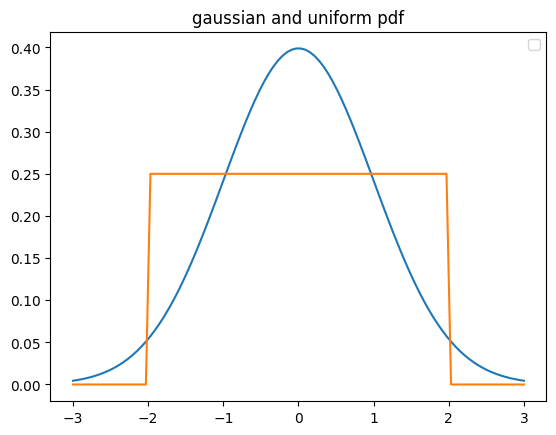

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False # Ensure LaTeX is not used

# complete this code
MyUniform = lambda x, a, b : 1/(b-a) * ((x>=a) & (x<=b))
MyGauss = lambda x, mu, sig: 1/(np.sqrt(2*np.pi)*sig) * np.exp(-((x - mu)**2)/(2 * sig**2))

N = 100
x = np.linspace(-3.,3.,N)

a,b = -2, 2
mu, sig = 0, 1

plt.figure()
plt.plot(x,MyGauss(x,mu,sig)) # , label =f"\\mathcal N({mu},{sig**2})$"
plt.plot(x,MyUniform(x,a,b)) # , label = f"$\\mathcal U({a},{b})$"
plt.title("gaussian and uniform pdf")
plt.legend()

Question : how to check *numerically* that this function is normalized, that is :
1. $$
    f(x) \ge 0
$$
Hints : you may use `np.all`

2. $$
    \int_{x\in \mathbb R} f(x) dx = 1
$$
Hints : you may use `np.sum` and you need do compute $dx$ from `x`; $dx$ is a constant for a regular grid of points $x$.


In [ ]:
print(f"MyGauss is non-negative: {np.all(MyGauss(x,mu,sig) >= 0)}")
print(f"MyUniform is non-negative: {np.all(MyUniform(x,a,b) >= 0)}")

dx = x[1] - x[0]

print(f"MyGauss is normalized: {np.isclose(np.sum(MyGauss(x,mu,sig)) * dx, 1, atol=0.01)}")
print(f"MyUniform is normalized: {np.isclose(np.sum(MyUniform(x,a,b)) * dx, 1, atol=0.01)}")

MyGauss is non-negative: True
MyUniform is non-negative: True
MyGauss is normalized: True
MyUniform is normalized: True




`scipy.stats.norm.pdf` corresponds to the centered ($\mu=0$) and normalized ($\sigma=1$) gaussian pdf:
$$
    f(x) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}}
$$
 `scipy.stats.uniform.pdf` corresponds to $\mathcal U([0,1])$

Use these functions to check your code

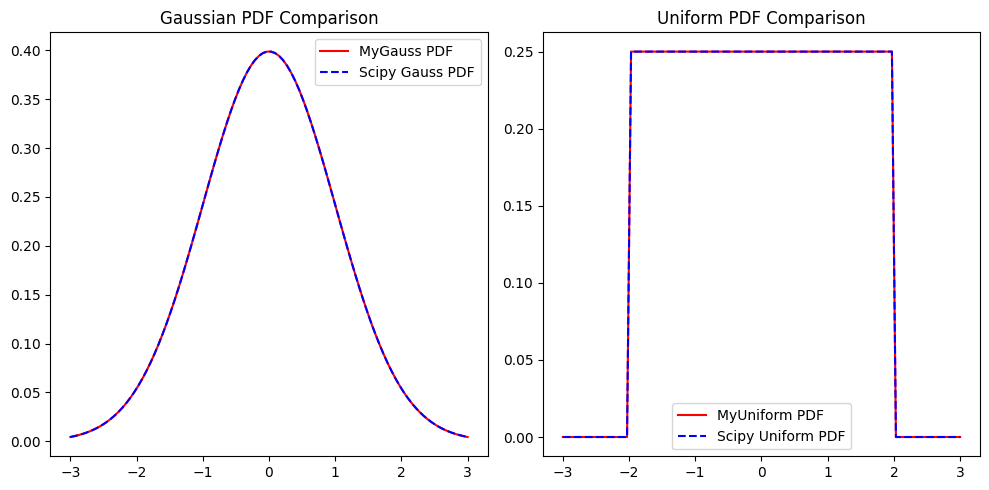

In [ ]:
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt

gauss_scipy = norm.pdf(x, loc=mu, scale=sig)
uniform_scipy = uniform.pdf(x, loc=a, scale=b-a)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(x, MyGauss(x, mu, sig), color="red", label="MyGauss PDF")
ax[0].plot(x, gauss_scipy, ls='--', color="blue", label="Scipy Gauss PDF")
ax[0].set_title("Gaussian PDF Comparison")
ax[0].legend()

ax[1].plot(x, MyUniform(x, a, b), color="red", label="MyUniform PDF")
ax[1].plot(x, uniform_scipy, ls='--', color="blue", label="Scipy Uniform PDF")
ax[1].set_title("Uniform PDF Comparison")
ax[1].legend()

plt.tight_layout()
plt.show()

---
## I-2. 1D random variables
<a class="anchor" id="section_1_2"></a>

Let $Z \sim \mathcal N(0,1)$ and $U \sim \mathcal U([0,1])$ be two random variables, (gaussian and uniform)

We want to generate a random variable $X \sim \mathcal N(\mu,\sigma^2)$ and $V \sim \mathcal U([a,b])$

The change of variable between $X$ and $Z$ is (**please complete**)
$$
    X = \sigma * Z + \mu
$$

Likewise, the change of variable between $V$ and $U$ is (**please complete**)
$$
    V = a + U * (b - a)
$$

1 - Implement these change of variables to generate two random arrays of  
$n$ samples $X \in \mathbb{R}^n$ and $V \in [a,b]^n$

2 - compute & plot the histogram for some parameters $a$, $b$, $\mu$ and $\sigma^2$

3 - compare with the pdf (beware of the normalisation of the histogram !)

hints :
- use `np.random.rand` or `scipy.stats.uniform.rvs` to generate $U$
- use `np.random.randn` or `scipy.stats.norm.rvs` to generate $Z$
- use `np.histogram` & `np.stairs` to compute & plot histograms and bin indices

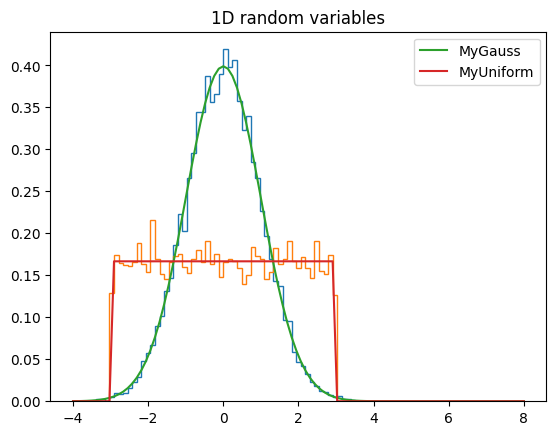

In [ ]:
# your code here

# sampling
n = 10_000
U = np.random.rand(n)
Z = np.random.randn(n)

# change of variables
a, b = -3, 3
V = a + ((b-a) * U)
mu, sig = 0, 1
X = (sig * Z) + mu

# histograms
N = 100
x = np.linspace(-4,8,N)
h_X,bins_x = np.histogram(X, bins=x, density=True)
h_V,bins_v = np.histogram(V, bins=x, density=True)

dx = x[1] - x[0]

# normalization
h_X = h_X / np.sum(h_X * dx)
h_V = h_V / np.sum(h_V * dx)

plt.figure()
plt.stairs(h_X, bins_x, label= "")
plt.stairs(h_V, bins_v, label= "")
plt.plot(x, MyGauss(x, mu, sig), label = "MyGauss")
plt.plot(x, MyUniform(x, a, b), label = "MyUniform")
plt.title("1D random variables")
plt.legend();

---
## I.3. Cumulative distributions, histograms and empirical repartition function
<a class="anchor" id="section_1_3"></a>

[Table of Contents (top)](#toc)

Let $f: \mathbb R \rightarrow \mathbb R$ be a pdf.
The cumulative probability distribution $F : \mathbb R \rightarrow [0,1]$ is defined as :
$$
F^{} (x) = \int_{
y \in (-\infty,x]} \;
f(y) \, dy
$$

The pseudo-inverse cumulative distribution $F^{-1} : [0,1]\rightarrow \mathbb R \cup \{-\infty\}$ is defined as :
$$
F^{-1} (t) = \inf_x \left \{
x \in \mathbb R \cup \{-\infty\}, \;
F(x) \ge t
\right \}
$$

The empirical estimation of $F$ can be obtained by :
- knowing $f$, computing approximately the integral (e.g. using `numpy.cumsum()`)
- using random samples, compute the cumulative histogram (e.g. using `np.histogram` and `numpy.cumsum()`)
- using sorted point cloud (e.g. using `numpy.sort()`)

1 - compute the cumulative distribution of $\mathcal N(\mu,\sigma^2)$ and $\mathcal U ([a,b])$
$$
    F(x_i) \approx \sum_{j\le i} f(x_j) (x_{j+1} - x_j )
$$
where $f(x_i)$ are the pdf values on points $(x_i)$ sampled on a regular grid

2 - compare with the empirical cumulative histograms
$$
    H[i] = \sum_{j\le i} h[j]
$$
where $h$ is the histogram computed from a random sample

3 - compare with the empirical repartition function :
- generate a random n-sample $X = (X_1, \ldots X_n)$
- sort values in ascending order : $X \circ \sigma$ such that $X_{ \sigma (1)} < X_{ \sigma (2)} < \ldots < X_{ \sigma (n)}$
- plot points $(X_{ \sigma (i)}, \frac{i}{n})$

In [ ]:
#your code here


____
# II . push-forward and optimal transport
<a class="anchor" id="section_2"></a>
[Table of Contents (top)](#toc)

## II.1 - reminders about change of variable with random variables
<a class="anchor" id="section_2_1"></a>



Recall about push-forward :

Let $\mu$ and $\nu$ two probability measures with densities $f$ and $g$ respectively
$$\mu(dx) = f(x)dx \text{ and } \nu(dx) = g(x)dx.$$

Let $T$ be a mapping such that the push-foward of $\mu$ with $T$ match $\nu$ which is noted as
$$
    T_\# \mu = \nu
$$
Then pdfs verifies (see course) : (**please complete**)
$$
    f(x) = g \circ T(x) \times ...
$$
where $T'$ indicates the derivative of the mapping

Conversely, we have  (**please complete**)
$$
    g(y) = f \circ T^{-1}(y) \times ...
$$


## II.2 - application of push-forward to pdf
<a class="anchor" id="section_2_2"></a>


---
Questions :

- what happen to the pdf $f(x)$ when using a change of variable $x=T^{-1}(y)$ ? is it still a pdf ?

- to illustrate your answer, plot $y \mapsto f\circ T^{-1}(y)$ for a gaussian $f_1 = \mathcal N(\mu,\sigma^2)$ and a uniform pdf $f_2 = \mathcal U ([a,b])$,
combined with increasing functions:
    - an affine map : $ y = T(x) = \alpha x+\beta $
    - a non-linear bijective map : $ y = T(x) = e^{\gamma x}$
    - (bonus) $y = x^2$ (Note : not bijective !)
    - (bonus) $y = x^3$ (Note : special required with sign in numpy)

- describes what happen when using the proper change of variable which requires the derivative :
$$
    g(y) = f \circ T^{-1}(y) \times ...
$$

- check your result by
    - drawing random samples $X$ from $f_1$ and $f_2$
    - apply the change of variable $Y = T(X)$
    - plot the normalized histogram of $Y$



In [ ]:
# your code here :
f = ... # pdf function with approriate parameters

N = 1_000 # number of points
x = np.linspace(...,N)

n = 100_000 # random sample size
X = ...

y = np.linspace(...,N)
T_inv = ...

plt.figure()
plt.plot(x,f(x)) # , label = "$f$"
plt.plot(y,f(T_inv)) # , label = "$ f \circ T^{-1} $"
plt.title("Changement de variable")
plt.legend();



TypeError: unsupported operand type(s) for -: 'int' and 'ellipsis'

## II-3. Wasserstein distance between 1D histograms & 1D point-clouds
<a class="anchor" id="section_2_3"></a>

Consider $\mu$ and $\nu$ two 1D probability measures with densities $f$ and $g$ respectively
$$\mu(dx) = f(x)dx \text{ and } \nu(dx) = g(x)dx.$$

In the original setting of the Monge transportation setting when using a cost function $c(x,y) = |x-y|$, the optimal transport cost is the Wasserstein-1 distance :
$$
    W_1(\mu, \nu) = \int_{\mathbb R} \lvert F(x) - G(x) \rvert dx = \|F-G\|_{1}
$$

In the case where $c(x,y) = |x-y|^2$, the optimal transport cost is the *quadratic* Wasserstein-2 distance :
$$
    W_2(\mu, \nu)^2 = \int_{[0,1]} \lvert F^{-1}(t) - G^{-1}(t) \rvert^2 dt = \|F^{-1}-G^{-1}\|_{2}^2
$$
which requires to compute the pseudo-inverse of the cumulative distribution functions (CDF)

---
1 - compute the Wasserstein-1 distance between two gaussian distributions
$f_0 = \mathcal N(\mu_0,\sigma_0^2)$ and $f_1 = \mathcal N(\mu_1,\sigma_1^2)$

then, check numerically that $W_1(f_0,f_1) = |\mu_1 - \mu_0|$ when $\sigma_0 = \sigma_1$

then, check numerically that the corresponding transport cost using $c(x,y) = |x-y|$ with the optimal map $T_{0\rightarrow 1}$ gives the same result :
$$
    OT(f_0,f_1) = \int_{\mathbb R} |T_{0\rightarrow 1}(x) - x| f_0(x) dx
$$
$$
    T_{0\rightarrow 1}(x) = \tfrac{\sigma_1}{\sigma_0} (x-\mu_0) + \mu_1
$$

In [ ]:
# your code here

---
2 - compute the Wasserstein-2 distance between two gaussian distributions
$f_0 = \mathcal N(\mu_0,\sigma_0^2)$ and $f_1 = \mathcal N(\mu_1,\sigma_1^2)$

check numerically that $W_2(f_0,f_1)^2 = |\mu_1 - \mu_0|^2 + (\sigma_0 - \sigma_1)^2$

then, check numerically that the corresponding transport cost using $c(x,y) = |x-y|^2$ with the optimal map $T_{0\rightarrow 1}$ gives the same result :
$$
    OT(f_0,f_1) = \int_{\mathbb R} |T_{0\rightarrow 1}(x) - x|^2 f_0(x) dx
$$
with
$$
    T_{0\rightarrow 1}(x) = \tfrac{\sigma_1}{\sigma_0} (x-\mu_0) + \mu_1

*Hints* : recall that
the pseudo-inverse CDF $F^{-1} : [0,1]\rightarrow \mathbb R \cup \{-\infty\}$ is defined as :
$$
F^{-1} (t) = \inf_x \left \{
x \in \mathbb R \cup \{-\infty\}, \;
F(x) \ge t
\right \}
$$


**Input:** $F$ (cumulative histogram values in [0,1]), $x$ (corresponding bin values in $\mathbb R$), $t$ (target bin values in [0,1] for inverse function)

**Output:** $F_{\text{inv}}$ (pseudo-inverse cumulative histogram for values in t $\in$ [0,1])

**Pseudo Code:**
1. Initialize F_inv as an array of zeros with the same shape as t
2. Set N to the size of F
3. Set j to 0
4. For each index i and value v in t:
    1. While F[j] < v :
        *   Increment j by 1
        *  If j >= N:
            - Set j to N - 1
            - Break the while loop
    1. Set F_inv[i] = x[j]
5. Return F_inv

you can use the function
```
    def pseudo_inverse(F,x,t) :
        F_inv = np.zeros_like(t)
        
        ...

        return F_inv      
```

In [ ]:
# your code here

## II.4 - Optimal mapping between 1D point-clouds
<a class="anchor" id="section_2_4"></a>


For N-point-clouds $X \in \mathbb R^{N \times d}$ and $Y \in \mathbb R^{N \times d}$, computing the optimal transport map $T$ boils down to compute an optimal assignment.

In the 1D case (d=1), when using ground cost function $c(x,y) = |x-y|^p$ with $p\ge 1$,
optimal assignment can be simply obtained by **matching points with the same ordering rank**.

The pseudo-algorithm writes as follows :
1) computes permutations $\sigma_X$ and $\sigma_Y$ sorting $X$ and $Y$ (in increasing order) :
$$
    X_{\sigma_X(1)} \le X_{\sigma_X(2)} \le ... \le X_{\sigma_X(N)}
$$
and
$$
    Y_{\sigma_Y(1)} \le Y_{\sigma_Y(2)} \le ... \le Y_{\sigma_Y(N)}
$$
2) defines the optimal assignement as
$$
    \sigma = \sigma_Y\circ\sigma_X^{-1}
$$
The corresponding "mapping" is $T: X_{\sigma_X(i)} \mapsto Y_{\sigma_Y(i)}$, that is
$$
    T: X_i \mapsto Y_{\sigma_Y\circ\sigma_X^{-1}(i)}
$$


Use the following code (`GMM` function) to generate and visualize two random samples $X_1$ and $X_2$ from two different probability distributions.

Compute the optimal assignement between the two point-clouds. Is it a 1-to-1 mapping ?

Hints : a simple trick to inverse a permutation $\sigma :  \{1 .. N\} \rightarrow \{1 .. N\}$ in python is to explicitely use the property :
$$
    \sigma^{-1} (\sigma(i)) = i
$$

In [ ]:
# complete the following code to compute optimal assignement between two set of points

# Gaussian mixture
def GMM(p = (.5,.5), mu = (0,1), sig = (1,1), N=1_000) :
    K = len(p)
    assert len(mu) == K
    assert len(sig) == K

    X = np.random.randn(N)
    m = 0
    for i in range(K-1) :
        n = int(p[i]*N)
        X[m:m+n] = mu[i] + sig[i] * X[m:m+n]
        m += n
    X[m:] = mu[K-1] + sig[K-1] * X[m:]

    return X

N = 10

# # gaussian mixture #1
p1 = (.3,.7)
X1 = GMM(p1,(0,1),(1,1),N)

# # gaussian mixture #2
p2 = (.5,.3,.2)
X2 = GMM(p2,(-.5,.5,1.5),(1,1,1),N)

# define optimal assignement 1->2
#assign_1to2 = ...

# apply transport as assignment
X12 = X2

plt.figure()
Y1 = np.zeros(N) # X1 is on the real line y=0
Y2 = np.ones(N) # for visualization, X2 is shifted to y=1
plt.plot(X1, Y1, 'or') # , label = "$X_1$"
plt.plot(X2, Y2, 'ob') # , label = "$X_2$"
plt.plot(X12, np.ones(N)) # , 'xc', label = "$X_{12}$"
plt.legend()

x = np.stack((X1,X12),axis=1).T
y = np.stack((Y1,Y2),axis=1).T
plt.plot(x, y, '--g');


The optimal transportation cost can be computed from the optimal mapping
$$
    \sigma = \sigma_Y\circ\sigma_X^{-1}
$$

Recall that for uniform probability measure supported on a point-cloud, we have :
$$
    p(x) = \frac 1N\sum_{i \in [N]} \delta(x - x_i)
\text{ and }
    q(y) = \frac 1N\sum_{j \in [N]} \delta(y - y_j)
$$

The Wasserstein-1 distance (OT with ground cost $c(x,y) = |x-y|$) is :
$$
    W_1(X,Y) = OT(p,q)
    = \frac{1}{N} \sum_{i=1}^N |X_i - Y_{\sigma(i)}|
    = \frac{1}{N} \sum_{i=1}^N |X_{\sigma_X(i)} - Y_{\sigma_Y(i)}|
$$

The Wasserstein-2 distance (OT with ground cost $c(x,y) = |x-y|^2$)  is :
$$
    W_2(X,Y) = \sqrt{OT(p,q)} = \sqrt{ \frac{1}{N} \sum_{i=1}^N |X_i - Y_{\sigma(i)}|^2}
$$

Using your previous code, compute the Wasserstein distance between two large point-clouds generated from Gaussian distributions (say $N=10^5$).

Compare with the Wasserstein distance between two Gaussian distributions (as done in previous question)

In [ ]:
# your code here

## II.5 - BONUS : Interpolaton between two pdfs and point-clouds
<a class="anchor" id="section_2_5"></a>


To interpolate between two probability measures $p_0$ and $p_1$, one can use the **Euclidean interpolation** (mixture model) :
$$
    p_\lambda(x) = (1 - \lambda) p_0 + \lambda p_1
$$

Show that the interpolate measure $p_\lambda$ is indeed a probability measure.

Plot interpolated $p_\lambda$ for various $\lambda$ using the following code for Gaussians

In [ ]:
# interpolation with euclidean distance
P = 11 # number of interpolated pdfs
N = int(1e2)
x = np.linspace(-5.,5.,N)

mu0, sig0 = -1,1
p_0 = 1./sig0 * scipy.stats.norm.pdf( (x-mu0)/sig0 )
mu1, sig1 = 1,0.5
p_1 = 1./sig1 * scipy.stats.norm.pdf( (x-mu1)/sig1 )

Lbd = np.linspace(0,1,P)
plt.figure()
for i,lbd in enumerate(Lbd) :

    p_lbd = lbd * p_1 + (1-lbd) * p_0

    Couleur = (1-lbd)*np.array((1.,0.,0.)) + lbd * np.array((0.,0.,1.))

    plt.plot(x,p_lbd,color=Couleur) # label=f"$\lambda = {lbd:.2}$"

plt.legend()
plt.title("Interpolation between two Gaussians using Euclidean distance");

An interesting alternative with optimal transport is the **interpolation of the push-forward** (a.k.a McCann interpolation) using optimal transport map $T$:
$$T_\lambda = (1 - \lambda) \text{Id} + \lambda T_{0\rightarrow 1} $$

For 1D gaussian pdfs $p_0 = \mathcal N(\mu_0,\sigma_0^2)$ and $p_1 = \mathcal N(\mu_1,\sigma_1^2)$ the optimal transport map for ground cost ($c(x,y) = |x-y|^p$, $p\ge 1$) writes:
$$T_{0\rightarrow 1} : x \mapsto  \mu_1 + \frac{\sigma_1}{\sigma_0}(x-\mu_0)$$
We can show (see course) that the interpolated pdf is gaussian:
$$
    p_\lambda = \mathcal N(\mu_\lambda,\sigma_\lambda^2)
$$
with
$$
    \sigma_\lambda =  (1 - \lambda) \sigma_0 + \lambda {\sigma_1}
$$
and
$$
    \mu_\lambda = (1 - \lambda) \mu_0 + \lambda {\mu_1}
$$

For various $\lambda \in [0,1]$ :
- Define the interpolated optimal map $T_\lambda$ and computes numerically the corresponding push-forward $T_\lambda {}_\# p_0 = p_\lambda$
as done in [II.2 - application to push-forward ](#section_2_2)

- in the gaussian case, compare with the closed-form formula of interpolated pdf given above to check your results

In [ ]:
# your code here

Bonus : Experiment with non-Gaussian pdfs (for instance using gaussian mixtures obtained by Euclidean Interpolation as provided by the code above)

In [ ]:
#your code here

Bonus : Experiment with non-Gaussian point-clouds (for instance using gaussian mixtures with the function `GMM`)

In [ ]:
#your code here

___
# III - BONUS : Optimal transport between 1D histograms : application to image specification
<a class="anchor" id="section_3"></a>


[Table of Contents (top)](#toc)


Using 1D pdfe $f$ (source) and $g = T_\# f$ (target) with a differential transport map $T$, we have the relation (see course)
$$
    g \circ T(x) \, |T'(x)| = f(x)
$$
Considering cumulative distribution functions $F$ and $G$ and an *increasing* monotonic map $T$, this boils down to
$$
    G \circ T = F
$$
The resulting map satisfies
$$
    T = G^{-1} \circ F
$$
using the pseudo-inverse of $G$.

---
### III.1 - Equalization using histograms
<a class="anchor" id="section_3_1"></a>

Let assume that $x \in [0,1]$ for simplicity.
For a target uniform distribution, we have $g(x) = \mathbb 1_{[0,1]}(x)$.
Then $G(x) = x = G^{-1}(x)$
The transport map writes simply :
$$
    T = F
$$

If $x \in [a,b]$, $g(x) = \tfrac 1{b-a} \mathbb 1_{[a,b]}(x)$ and
$G(x) = \tfrac {x-a}{b-a}$ and $G^{-1}(t) = (b-a)t+a$.
$$
    T(x) = (b-a) F(x) + a
$$
For 8-bit images, pixel values are between a=0 and b=255

Complete the following code to perform gray values equalization

In [ ]:
# Complete this code !
# experiment on a gray valued image

im0 = plt.imread("pics/flower_gray.jpg")
H,W,C = im0.shape
print(f"input range : [{im0.min()},{im0.max()}]")

fig, ax = plt.subplots()
plt.imshow(im0,cmap='gray')
plt.axis('off')

im = im0[:,:,0].copy() # select only one channel
X = im.reshape(-1) # 1D point cloud
bins = np.arange(257) # 0 to 256
f = ... # histogram (pdf)
F = ... # cumulative probability functio (CDF)

fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
ax0.stairs(f,bins,label="empirical hist")
ax1.stairs(F,bins,label="empirical rep. fun.")

# define transport map from F
T = ...
# apply transport map (on already quantized pixel values) X
Y = ...

# for visualisation : compute the histogram g and CDF G
g = ...
G = ...

ax0.stairs(g,bins,label="hist after transport")
ax0.legend()
ax1.stairs(G,bins,label="empirical rep. fun. after transport")
ax1.legend()

# reshape Y as an image
im = Y.reshape(H,W,1)
im = np.repeat(im, 3, axis=2)
print(f"output range : [{im.min()},{im.max()}]")

fig, ax = plt.subplots()
plt.imshow(im/255,cmap='gray')  # /255 because float image should be in [0,1]
plt.axis('off')



---
### III.2 - Specification using histograms
<a class="anchor" id="section_3_2"></a>

Now we consider an arbritrary target histogram / pdf $g(x)$, which requires to compute the pseudo-inverse CDF $G^{-1}$ to compute the optimal map :
$$
    T = G^{-1} \circ F
$$

Define a function to compute $T$ from a CDF $F$ and $G$.

Apply this function to specificy RGB channels of a color image given a target image

Note : one can use the previously defined function defined ```pseudo_inverse```, but here we can take advantage of the fact that both $F$ and $G$ are on quantized values {0,..255}

In [ ]:
# complete this code

# experiment on image pairs :
im1 = plt.imread("pics/flashno_1_small.jpg")
H1,W1,C = im1.shape
im2 = plt.imread("pics/flash_2_small.jpg")
H2,W2,C = im2.shape
print(f"input range : [{im1.min()},{im1.max()}]")

fig, ax = plt.subplots()
plt.imshow(np.concatenate((im1,im2), axis=1),cmap='gray')
plt.axis('off')

im_rgb = im1.copy()
for c in range(C):
    x1 = im1[:,:,c].copy() # select only one channel
    X1 = x1.reshape(-1)
    x2 = im2[:,:,c].copy() # select only one channel
    X2 = x2.reshape(-1)

    # compute CDF
    bins = np.arange(257)
    f1 = ...
    F1 = ...
    f2 = ...
    F2 = ...

    fig0, ax0 = plt.subplots()
    ax0.stairs(f1/f1.max(),bins,label="empirical hist1", linewidth = 4, alpha=.5)
    ax0.stairs(f2/f2.max(),bins,label="empirical hist2", linewidth = 4, alpha=.5)
    ax0.stairs(F1,bins,label="empirical rep. fun. 1", linewidth = 4, alpha=.5)
    ax0.stairs(F2,bins,label="empirical rep. fun. 2", linewidth = 4, alpha=.5)

    # define $T = F2^{-1} \circ F1$
    T = ...

    # apply transport map T
    X12 = T[X1]


    # compute resulting CDF
    g = ...
    G = ...

    ax0.stairs(g/g.max(),bins,label="hist after transport", linewidth = 2, alpha=.9)
    ax0.legend()
    ax0.stairs(G,bins,label="empirical rep. fun. after transport", linewidth = 2, alpha=.9)
    ax0.legend()

    im_rgb[:,:,c] = X12.reshape(H1,W1)
    print(f"output range : [{X12.min()},{X12.max()}]")

fig, ax = plt.subplots()
plt.imshow(im_rgb/255,cmap='gray')  # /255 because float image should be in [0,1]
plt.axis('off')


---
### III.3 - Specification using point-cloud optimal assignment
<a class="anchor" id="section_3_3"></a>

Using sorting algorithms, achieve this task using optimal assignment between point-clouds of gray values.

How the two methods differs in terms of time complexity and optimal mapping ?

Reminder : For N-point-clouds in the 1D case, optimal assignment can be simply defined by matching points with the same ordering rank.
The specification writes as follows :
1) computes permutations $\sigma_X$ and $\sigma_Y$ sorting $X$ and $Y$ (in increasing order) :
$$
    X_{\sigma_X(1)} \le X_{\sigma_X(2)} \le ... \le X_{\sigma_X(N)}
$$
and
$$
    Y_{\sigma_Y(1)} \le Y_{\sigma_Y(2)} \le ... \le Y_{\sigma_Y(N)}
$$
2) defines "mapping" as $T: X_{\sigma_X(i)} \mapsto Y_{\sigma_Y(i)}$, that is
$$
    T: X_i \mapsto Y_{\sigma_Y\circ\sigma_X^{-1}(i)}
$$


In [ ]:
# complete this code

if im1.shape != im2.shape :
    raise "the two images should have the same size !"

N = H1*W1

fig, ax = plt.subplots()
plt.imshow(np.concatenate((im1,im2), axis=1),cmap='gray')
plt.axis('off')

im_rgb2 = im1.copy()
for c in range(C):
    x1 = im1[:,:,c].copy() # select only one channel
    X1 = x1.reshape(-1)
    x2 = im2[:,:,c].copy() # select only one channel
    X2 = x2.reshape(-1)

    # sort each channel values
    ...

    # define optimal assignement 1->2
    ...

    # apply transport as assignment
    X12 = ...

    im_rgb2[:,:,c] = X12.reshape(H1,W1)
    print(f"output range : [{X12.min()},{X12.max()}]")

fig, ax = plt.subplots()
plt.imshow(im_rgb2/255,cmap='gray')  # /255 because float image should be in [0,1]
plt.axis('off')